In [49]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle as pickle
%matplotlib inline
from skimage.feature import hog

In [4]:
pwd

'F:\\IT\\LEARN\\AI\\COURSES\\UDACITY\\SDCND\\PROJECTS\\P5_VEHICLE_DETECTION_TRACKING\\CarND-Vehicle-Detection'

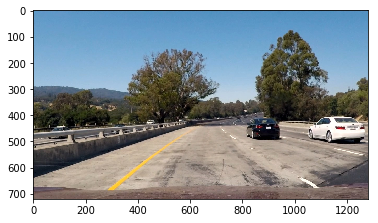

In [5]:
# Now undistort a lane road image
img = plt.imread('test_images/test1.jpg')
plt.imshow(img, cmap="gray")

In [25]:
img.shape

(720, 1280, 3)

## READ THE DATA

In [37]:
img = plt.imread("vehicles/vehicles/GTI_Right/image0001.png")

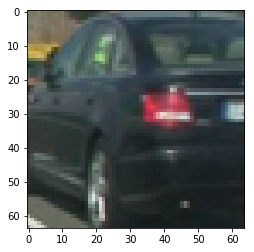

In [39]:
plt.imshow(img)

In [40]:
img.shape

(64, 64, 3)

## FEATURE EXTRACTION

In [76]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [77]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [100]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## SINGLE IMAGE PIPELINE

In [111]:
img = plt.imread("vehicles/vehicles/GTI_Right/image0001.png")

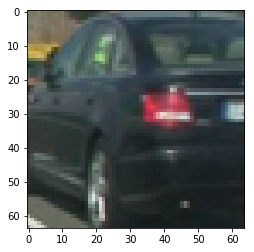

In [112]:
plt.imshow(img)

In [113]:
im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

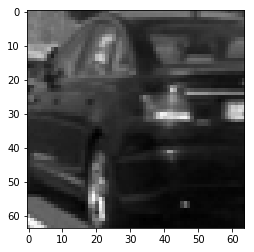

In [114]:
plt.imshow(im, cmap="gray")

In [115]:
features, hog_image = get_hog_features(im, 9, 2, 2, True)

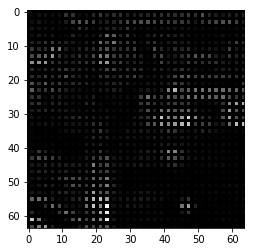

In [116]:
plt.imshow(hog_image, cmap="gray")

In [117]:
#from skimage.feature import hog
#features, hog_image = hog(im, orientations=9,
#                          pixels_per_cell=(2, 2),
#                          cells_per_block=(2, 2),
#                          transform_sqrt=False,
#                          visualise=True, feature_vector=False)

In [133]:
car_images = glob.glob('vehicles/vehicles/*/*.png')

In [134]:
len(car_images)

8792

In [135]:
noncar_images = glob.glob('non-vehicles/non-vehicles/*/*.png')

In [136]:
len(noncar_images)

8968

In [138]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in images:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [139]:
car_features = extract_features(car_images)

In [140]:
noncar_features = extract_features(noncar_images)

In [148]:
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features))

In [149]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [151]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [154]:
# Split up data into randomized training and testing set
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=rand_state)

In [155]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [156]:
svc.score(X_test, y_test)

0.93524774774774777

In [159]:
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.]


In [36]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)                
    return draw_img

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

## SLIDING WINDOWS IMPLEMENTATION

In [27]:
def draw_bboxes(img, bboxes, color = (0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return imcopy

In [28]:
# function for sliding window implementation
# x_start_stop, y_start_stop - start and stop positions in both x and y
# xy_window - window size (x and y dimensions)
# xy_overlap - overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # compute the number of pixel per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    windows = []
    for x in range(x_start_stop[0], x_start_stop[1], nx_pix_per_step):
        for y in range(y_start_stop[0], y_start_stop[1], ny_pix_per_step):
            windows.append(((x, y), (x + nx_pix_per_step - 1, y + ny_pix_per_step - 1)))
    
    return windows

In [30]:
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [32]:
window_img = draw_bboxes(img, windows, color=(0, 0, 255), thick = 6)

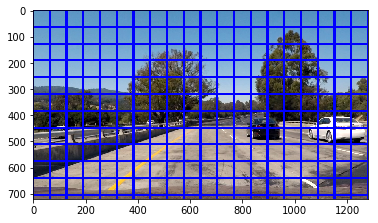

In [33]:
plt.imshow(window_img)

In [11]:
a = [1, 2, 3]
b = [3, 4, 5]

In [14]:
c = np.concatenate((a, b))

In [15]:
print(c)

[1 2 3 3 4 5]


In [141]:
np.vstack((a, b)).astype(np.float64)

array([[ 1.,  2.,  3.],
       [ 3.,  4.,  5.]])

In [142]:
np.concatenate((a, b))

array([1, 2, 3, 3, 4, 5])

In [143]:
a1 = [[1, 2, 3], [4, 5, 6]]
b1 = [[1, 2, 3], [4, 5, 6]]
np.concatenate((a1, b1))

array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [144]:
np.hstack((a1, b1))

array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6]])

In [145]:
np.vstack((a1, b1))

array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])